# Average Joe

The program to average all the MIR-spectra in a folder

First we load the libraries we will need

In [59]:
# This will be necessary
import numpy as np

# With this we will plot the figures
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

# This library will help us with the differente SO
from pathlib import Path 

# to decompress the mzz files
import zipfile 
import zlib

# Always useful knowing how much is left
from tqdm import tqdm

# to export a file with the averaged spectrum
import csv 




Now we declare the folder where the spectra to average are (they can be .dpt or .mzz files)

In [60]:
spectra_path = input("Please, indicate the folder location: ")

Now the algorithm works

In [61]:
# This part is copied from loco mosquito
#  we include the path module that helps a lot with the / or \ problem
spectra_path = Path(spectra_path)
# find all the .mzz and .dpt files in the folder (and its subfolders)
dptfiles = []
mzzfiles = []
for root, dirs, files in os.walk(spectra_path):
    for file in files:
        if file.endswith(".dpt"):
             dptfiles.append(Path(root) / Path(file))
        elif file.endswith(".mzz"):
             mzzfiles.append(Path(root) / Path(file))
             
# If there are *.mzz files, we will not consider the *.dpt files
if len(mzzfiles) > 0:
    spectra_names = mzzfiles
else:
    spectra_names = dptfiles

# We define now a function to extract easily the info from the files:
def extractineitor(filename):
    # If the file has an dpt extension:
    if str(filename)[-1] == "t":
        # Read it
        with open(filename, 'rb') as tmp:
            avmi = (line.replace(b'\t',b',') for line in tmp)
            spectrum = np.genfromtxt(avmi, delimiter=',')
        # And extract first and last wavenumbers and also the resolution and the absorbance data
        start = min(spectrum[0,0],spectrum[-1,0])
        end = max(spectrum[0,0],spectrum[-1,0])
        ls = len(spectrum)
        if spectrum[0,0] > spectrum[-1,0]:
            spectrum = np.flip(np.transpose(spectrum)[1])
        else:
            spectrum = np.transpose(spectrum)[1]

    # If not it is a mzz file   
    else:
        with zipfile.ZipFile(filename) as myzip:
            tmpname = myzip.namelist()[0]
            with myzip.open(tmpname) as myfile:
                spectrum = np.genfromtxt(myfile, delimiter=',')
        start = min(spectrum[0],spectrum[1])
        end = max(spectrum[0],spectrum[1])
        ls = int(spectrum[2])
        if spectrum[0] > spectrum[1]:
            spectrum = np.flip(spectrum[3:])
        else:
            spectrum = spectrum[3:]
    
    # Either way, return the good info from the file
    return [start,end,ls,spectrum]

In [62]:
# Now we average the spectra.
# We are going to use the first spectrum as reference:
# Number of spectra:
ns = 1
# First wavenumber, last wavenumber, resolution, spectrum:
[fw,lw,res,spc] = extractineitor(spectra_names[0])

# Now the algorithm to average the spectra:
for i in tqdm(range(1,len(spectra_names))):
    # First, we extract the info from the opened file:
    [tfw,tlw,tres,tspc] = extractineitor(spectra_names[i])

    # If the parameters are the same we just add the new spectrum:
    if [tfw,tlw,tres] == [fw,lw,res]:
        ns += 1
        spc = spc + tspc
    # If the parameters are different, we have to adapt to the poorest spectrum
    else:
        # Which one is better?
        if fw < tfw or lw > tlw or res > tres:
            # If the previous spectra are better...
            tmp = []
            for j in np.arange(tfw,tlw,(tlw-tfw)/tres):
                tmp.append(np.interp(j,np.arange(fw,lw,(lw-fw)/res),spc))
            spc = np.array(tmp)
            spc = spc + tspc
            ns += 1
            fw = tfw
            lw = tlw
            res = tres
        else:
            tmp = []
            for j in np.arange(fw,lw,(lw-fw)/res):
                tmp.append(np.interp(j,np.arange(tfw,tlw,(tlw-tfw)/tres),tspc))
            tspc = np.array(tmp)
            spc = spc + tspc
            ns += 1
# And promediate
spc = spc / ns




100%|██████████| 7280/7280 [03:49<00:00, 31.70it/s]


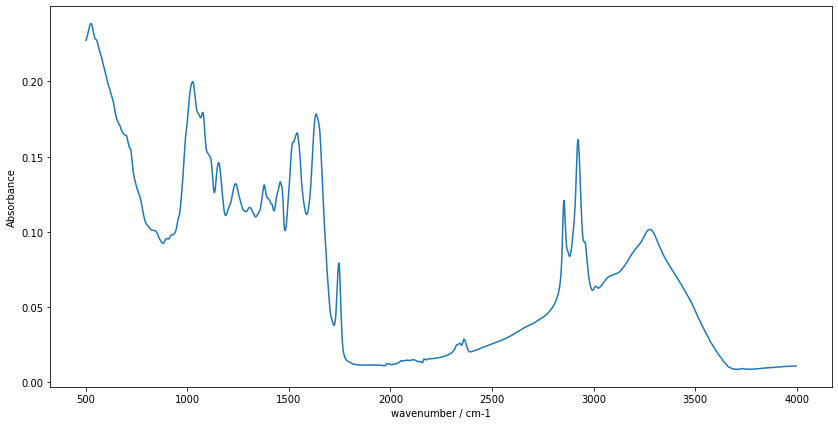

In [63]:
# we draw the plot
plt.figure(figsize=(14,7))
plt.plot(np.arange(lw,fw,-(lw-fw)/res),np.flip(spc))
plt.xlabel("wavenumber / cm-1")
plt.ylabel("Absorbance")

fig1 = plt.gcf()

plt.show()

Now if we want, we can export the results as a datapoint table and an image

In [64]:
# Figure

fig1.savefig(spectra_path / Path("spectrum.png"), dpi=150)

# File
with open(spectra_path / Path("averaged_spectrum.dat"), 'w', newline='') as file:
    sc = csv.writer(file, delimiter='\t')
    for i in np.transpose([np.arange(lw,fw,-(lw-fw)/res),np.flip(spc)]):
            sc.writerow(i)
